# Load Libraries and data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy.stats
from scipy.stats import chi2
warnings.filterwarnings('ignore')

In [3]:
# The data is contains review results of 3 reviewers for each item based on 9 question critieria
# Separate dataframes for each reviewer
compare = pd.read_excel('data.xlsx')
reviewer1 = compare[['q1_reviewer1', 'q2_reviewer1', 'q3_reviewer1', 'q4_reviewer1',
       'q5_reviewer1', 'q6_reviewer1', 'q7_reviewer1', 'q8_reviewer1',
       'q9_reviewer1']]
reviewer2 = compare[['q1_reviewer2', 'q2_reviewer2', 'q3_reviewer2',
       'q4_reviewer2', 'q5_reviewer2', 'q6_reviewer2', 'q7_reviewer2',
       'q8_reviewer2', 'q9_reviewer2']]
reviewer3 = compare[['q1_reviewer3', 'q2_reviewer3',
       'q3_reviewer3', 'q4_reviewer3', 'q5_reviewer3', 'q6_reviewer3',
       'q7_reviewer3', 'q8_reviewer3', 'q9_reviewer3']]

# 1.1 Agreement rate among each question: Calculate the agreement rate, defined as whether the reviewers all come to the same consensus. Any deviation from consensus is considered disagreement.

In [4]:
compare_result = pd.DataFrame()
questions = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9']

for question in questions:
  compare_result[f'{question}'] = compare.apply(lambda x: True if (float(x[f"{question}_reviewer1"]) == float(x[f"{question}_reviewer2"]) 
                                                               and float(x[f"{question}_reviewer2"]) == float(x[f"{question}_reviewer3"])) else False, axis=1)
print(compare_result.sum()/len(compare_result))

q1    0.810864
q2    0.820681
q3    0.966623
q4    0.793194
q5    0.989529
q6    0.970550
q7    0.615838
q8    0.289267
q9    0.496728
dtype: float64


#2.1 Interrater Agreement using Fleiss Kappa measurement on each questions
-  Fleiss Kappa is a statistical measure for assessing the reliability of agreement between a fixed number of raters when assigning categorical ratings to a number of items or classifying items.

# Kappa function definition

In [6]:
def fleiss_kappa(M):
  """
  See `Fleiss' Kappa <https://en.wikipedia.org/wiki/Fleiss%27_kappa>`.

  This function calculates Fleiss Kappa
  
  Params:
  M: a matrix of shape N x k where `N` is the number of subjects and `k` is the number of categories into which assignments are made.
  M[i, j] represents the number of raters who assigned the `i`th subject to the `j`th category: numpy matrix
  """
  N, k = M.shape  # N is # of items, k is # of categories
  n_annotators = float(np.sum(M[0, :]))  # # of annotators

  p = np.sum(M, axis=0) / (N * n_annotators)
  P = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
  Pbar = np.sum(P) / N
  PbarE = np.sum(p * p)

  kappa = (Pbar - PbarE) / (1 - PbarE)

  return kappa

In [7]:
# ratings for questions 1 General
kappa_value_l = []
for i in range(1,10):
  compare[f'No_{i}'] = compare.apply(lambda x : 3 - (float(x[f'q{i}_reviewer1']) + float(x[f'q{i}_reviewer2']) + float(x[f'q{i}_reviewer3'])), axis=1)
  compare[f'Yes_{i}'] = compare.apply(lambda x :(float(x[f'q{i}_reviewer1']) + float(x[f'q{i}_reviewer2']) + float(x[f'q{i}_reviewer3'])), axis=1)
  kappa = compare[[f'Yes_{i}',f'No_{i}']]
  kappa = kappa.values
  kappa_value = fleiss_kappa(kappa)
  kappa_value_l.append(kappa_value)

result_g1 = {"Criteria" : ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9'], "Kappa" : kappa_value_l }
pd.DataFrame(result_g1)

,Criteria,Kappa
0,q1,0.649255
1,q2,0.545445
2,q3,0.093997
3,q4,0.399111
4,q5,0.715764
5,q6,0.460586
6,q7,0.177324
7,q8,0.052344
8,q9,0.223335


In [8]:
# I don't understand what this is doing
for i,name in zip([reviewer1, reviewer2, reviewer3], ['reviewer1', 'reviewer2', 'reviewer3']): 
  i["score_3"] = i[f'q4_{name}'].astype(float) + i[f'q7_{name}'].astype(float) * 1/3  +  i[f'q8_{name}'].astype(float) * 1/3 +  i[f'q9_{name}'].astype(float) * 1/3
  i["score2"] = i.apply(lambda x : 2 if (float(x[f'q2_{name}']) + 2*float(x[f'q3_{name}'])) > 2 else (float(x[f'q2_{name}']) + 2*float(x[f'q3_{name}'])), axis=1) + i.apply(lambda x : 3 if (2*float(x[f'q5_{name}']) + 2*float(x[f'q6_{name}'])) > 3 else (2*float(x[f'q5_{name}']) + 2*float(x[f'q6_{name}'])), axis=1)
  i["final_score"] = i["score_3"] + i["score2"]
  i.drop(["score2","score_3"], inplace= True, axis= 1)
  i['final_score_1'] = i.apply(lambda x : round(x["final_score"]), axis= 1)
  i["classification"] = i.apply(lambda x : "Others" if x['final_score_1'] <= 1 else ("target1" if x['final_score_1'] >= 4 else "target2") , axis= 1)

In [9]:
# I don't know what is going on here. You need more descriptive columns
final_group = pd.merge(reviewer1, reviewer2, left_index=True, right_index=True)[['final_score_x', 'final_score_1_x', 'final_score_y', 'classification_x', 'final_score_1_y', 'classification_y']]
final_group = final_group.merge(reviewer3, left_index=True, right_index=True)[['final_score_x', 'final_score_1_x', 'final_score_y','final_score', 'classification_x', 'final_score_1_y', 'classification_y','classification']]
final_group = final_group.rename(columns={"final_score_x": "final_score_r1","final_score_y": "final_score_r2","final_score": "final_score_r3"})
final_group['avg'] = final_group.apply(lambda x: (x["final_score_r1"]+x["final_score_r2"]+x["final_score_r3"])/3, axis= 1)
final_group['avg_round'] = final_group.apply(lambda x: round(x["avg"]), axis= 1)
final_group['avg_classification'] = final_group.apply(lambda x : "Others" if x["avg_round"] <= 1 else ("target1" if x["avg_round"] >= 4 else "target2") , axis= 1)
final_group

,final_score_r1,final_score_1_x,final_score_r2,final_score_r3,classification_x,final_score_1_y,classification_y,classification,avg,avg_round,avg_classification
0,2.333333,2,3.000000,2.000000,target2,3,target2,target2,2.444444,2,target2
1,0.666667,1,0.666667,0.000000,Others,1,Others,Others,0.444444,0,Others
2,2.333333,2,2.000000,2.000000,target2,2,target2,target2,2.111111,2,target2
3,1.000000,1,0.666667,0.000000,Others,1,Others,Others,0.555556,1,Others
4,0.333333,0,1.000000,0.000000,Others,1,Others,Others,0.444444,0,Others
...,...,...,...,...,...,...,...,...,...,...,...
1523,0.333333,0,0.000000,0.333333,Others,0,Others,Others,0.222222,0,Others
1524,1.333333,1,0.333333,0.000000,Others,0,Others,Others,0.555556,1,Others
1525,0.000000,0,0.000000,0.000000,Others,0,Others,Others,0.000000,0,Others
1526,0.333333,0,0.000000,0.000000,Others,0,Others,Others,0.111111,0,Others


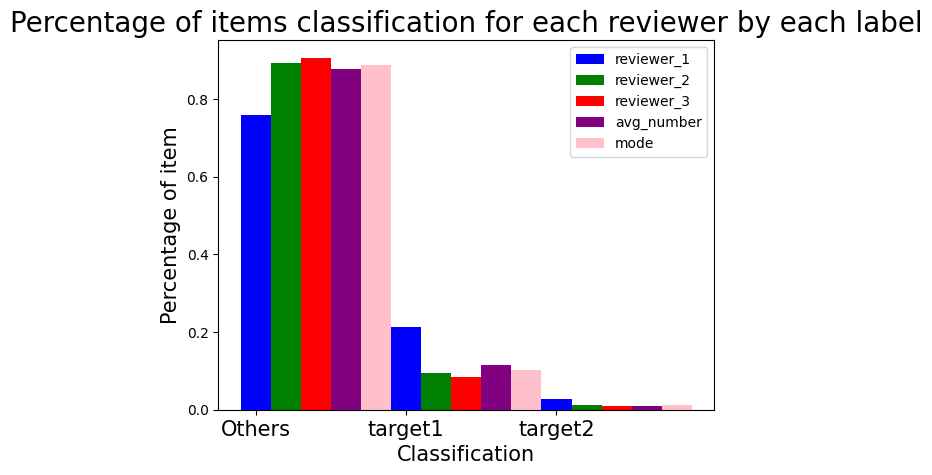

In [19]:
final_group["mode"] = final_group[["classification_x","classification_y","classification"]].mode(axis = 1)[0] 
reviewer_1 = pd.DataFrame(final_group.groupby('classification_x').count()['final_score_r1']).rename(columns = {"final_score_r1": 'number'})
reviewer_2 = pd.DataFrame(final_group.groupby('classification_y').count()['final_score_r1']).rename(columns = {"final_score_r1": 'number'})
reviewer_3 = pd.DataFrame(final_group.groupby('classification').count()['final_score_r1']).rename(columns = {"final_score_r1": 'number'})
avg = pd.DataFrame(final_group.groupby('avg_classification').count()['final_score_r1']).rename(columns = {"final_score_r1": 'number'})
mode = pd.DataFrame(final_group.groupby('mode').count()['final_score_r1']).rename(columns = {"final_score_r1": 'number'})


reviewer_1["number_avg"] = avg["number"]
avg = reviewer_1
avg["reviewer_2"] = reviewer_2["number"]
avg['reviewer_3'] = reviewer_3['number']
avg = avg.sort_values('number', ascending= False)
avg["mode"] = mode['number']

label = ['Others', 'target1', 'target2']
index = np.arange(len(label))

plt.bar(index + 0.00, avg["number"]/1528, color = 'blue', width = 0.2)
plt.bar(index + 0.2, avg["reviewer_2"]/1528, color = 'green', width = 0.2)
plt.bar(index + 0.4, avg["reviewer_3"]/1528 , color = 'red', width = 0.2)
plt.bar(index + 0.6, avg["number_avg"]/1528 , color = 'purple', width = 0.2)
plt.bar(index + 0.8, avg["mode"]/1528 , color = 'pink', width = 0.2)

plt.xlabel('Classification', fontsize=15)
plt.ylabel('Percentage of item', fontsize=15)
plt.xticks(index, label, fontsize=15, rotation=0)
plt.title('Percentage of items classification for each reviewer by each label',fontsize=20)
plt.legend(('reviewer_1',"reviewer_2","reviewer_3","avg_number","mode"))
plt.show()

# 2.2 Error rate for the overall result and for each reviewers

# Error rate gives you information as to which reviewers tend to have the most disagreement with the actual end result. This lets us know which reviewer is more likely to have biased result comparing to the actual result; The analysis shows that reviewer 1 has the most error rate.


In [11]:
# AVG
group1_err = 1 - pd.DataFrame(avg["number_avg"]/1528)["number_avg"][0]
group1_err_r1 = 1 - pd.DataFrame(avg["number"]/1528)["number"][0]
group1_err_r2= 1 - pd.DataFrame(avg["reviewer_2"]/1528)["reviewer_2"][0]
group1_err_r3 = 1 - pd.DataFrame(avg["reviewer_3"]/1528)["reviewer_3"][0]

print("Group_avg", group1_err,  "reviewer_1", group1_err_r1, "reviewer_2", group1_err_r2 , "reviewer_3", group1_err_r3)

Group_avg 0.12434554973821987 reviewer_1 0.2421465968586387 reviewer_2 0.1086387434554974 reviewer_3 0.09424083769633507


# 2.3 Result agreement rate between reviewers- Fleiss_Kappa

In [12]:
inter_group1 = final_group[["classification_x","classification_y","classification"]]
inter_group1['others_r1'] = inter_group1.apply(lambda x : 1 if x['classification_x'] == 'Others' else 0, axis=1)
inter_group1['others_r2'] = inter_group1.apply(lambda x : 1 if x['classification_y'] == 'Others' else 0, axis=1)
inter_group1['others_r3'] = inter_group1.apply(lambda x : 1 if x['classification'] == 'Others' else 0, axis=1)

inter_group1["No"] = inter_group1.apply(lambda x : 3 - (float(x["others_r1"]) + float(x["others_r2"]) + float(x["others_r3"])), axis=1)
inter_group1["Yes"] = inter_group1.apply(lambda x : (float(x["others_r1"]) + float(x["others_r2"]) + float(x["others_r3"])), axis=1)

kappa_Group1= inter_group1[['Yes','No']]
kappa1= kappa_Group1.values
kappa1 = fleiss_kappa(kappa1)
kappa1

0.47507232401157196

# 3 Statistical Inference and Analysis

Chi-square testing to determine if there is a relationship between the questions and the classification result.
 

In [13]:
# Relationship between each question and the classification result

def chi_square(m,n):
  contingency_table=pd.crosstab(m,n)
  Observed_Values = contingency_table.values
  #Expected Values

  b=scipy.stats.chi2_contingency(contingency_table)
  Expected_Values = b[3]
  #Degree of Freedom
  no_of_rows=len(contingency_table.iloc[0:2,0])
  no_of_columns=len(contingency_table.iloc[0,0:3])
  df=(no_of_rows-1)*(no_of_columns-1)
  #Significance Level 5%
  alpha=0.05
  #chi-square statistic - χ2

  chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
  chi_square_statistic=chi_square[0]+chi_square[1]
  #critical_value
  critical_value=chi2.ppf(q=1-alpha,df=df)
  # p-value
  p_value=1-chi2.cdf(x=chi_square_statistic,df=df)
  print('p-value:',p_value)
  print('Significance level: ',alpha)
  print('Degree of Freedom: ',df)
  print('chi-square statistic:',chi_square_statistic)
  print('critical_value:',critical_value)
  print('p-value:',p_value)

  chi_square.astype(int)> 0.09*(chi_square_statistic).astype(int)
  if p_value<=alpha:
      print("Reject H0,There is a relationship between 2 categorical variables")
  else:
      print("Retain H0,There is no relationship between 2 categorical variables")

In [14]:
chi_square(reviewer1["q1_reviewer1"],reviewer1["classification"])

p-value: 0.0
Significance level:  0.05
Degree of Freedom:  2
chi-square statistic: 171.69398475391296
critical_value: 5.991464547107979
p-value: 0.0
Reject H0,There is a relationship between 2 categorical variables
Reject H0,There is a relationship between 2 categorical variables


In [15]:
# Relationship between each question and the classification result
chi_square(reviewer2["q1_reviewer2"],reviewer2["classification"])

p-value: 0.0
Significance level:  0.05
Degree of Freedom:  2
chi-square statistic: 85.24360537287478
critical_value: 5.991464547107979
p-value: 0.0
Reject H0,There is a relationship between 2 categorical variables
Reject H0,There is a relationship between 2 categorical variables


In [16]:
# Relationship between each question and the classification result
chi_square(reviewer3["q1_reviewer3"],reviewer2["classification"])

p-value: 0.0
Significance level:  0.05
Degree of Freedom:  2
chi-square statistic: 103.10506854625551
critical_value: 5.991464547107979
p-value: 0.0
Reject H0,There is a relationship between 2 categorical variables
Reject H0,There is a relationship between 2 categorical variables


#3.2 Hypothesis test among reviewers classification results (ANOVA F-test)

# This is to test if there are any significant differences between each reviewers final decisions.

ANOVA Hypothesis

- Null hypothesis: Groups means are equal (no variation in error rate of groups)
- Alternative hypothesis: At least, one group mean is different from other groups

In [17]:
#import scipy.stats as stats
group1f=  reviewer1.apply(lambda x : 1 if x['classification'] == 'Others' else 0, axis=1)
group2f=  reviewer2.apply(lambda x : 1 if x['classification'] == 'Others' else 0, axis=1)
group3f= reviewer3.apply(lambda x : 1 if x['classification'] == 'Others' else 0, axis=1)
print(scipy.stats.f_oneway(group1f,group2f,group3f))
f, p = scipy.stats.f_oneway(group1f,group2f,group3f)
print("p-value for significance is: ", p)
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

F_onewayResult(statistic=83.3167917474773, pvalue=2.8743334120666532e-36)
p-value for significance is:  2.8743334120666532e-36
reject null hypothesis


# Conclusion:
Based on the kappa result as well as the agreement rate compare to the actual label, we are able to determine: 
- 1) which question most likely to subject to disagreement rate, in this case is question 3 and 8.
- 2) which reviewers are most likely to subject to bias, in this case would be reviewer 1 since he has the lowest agreement rate.
- 3) There is a relationship between rubric questions to the final classification results for each reviewer.
- 4) The agreement rate for the overall group, in this case would be 0.47 based on kappa score.